In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import defaultdict
from src.plotting import plot_sim_evaluation_pv

import seaborn as sns
sns.set_theme(palette="colorblind")
sns.set_style("white", {'axes.grid': False})
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from datetime import datetime, timedelta

seconds_in_day = 24 * 3600


def bar_line(theta, r=1, length=0.01):
    # Function to create end bars at arc limits
    r1 = r - length / 2
    r2 = r + length / 2
    return [theta, theta], [r1, r2]


def seconds_since_midnight(dt):
    # Convert datetime to seconds since midnight
    return dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6


def _to_angle(v):
    dt = datetime(2000, 1, 1) + timedelta(minutes=v)
    seconds = seconds_since_midnight(dt)
    angle = (seconds / seconds_in_day) * 2 * np.pi

    return angle


def plot_times(times, labels, ax=None):
    labels = list(labels)

    # Create polar plot
    if not ax:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    for i, values in enumerate(times):
        r = i * 0.1

        mean_angle = _to_angle(np.mean(values))
        std_angle = _to_angle(np.std(values))
        median_angle = _to_angle(np.median(values))

        # Arc for ±1 std
        theta = np.linspace(mean_angle - std_angle,
                            mean_angle + std_angle, 100)

        y = ax.plot(mean_angle, r, 'o')
        color = y[0].get_color()

        # ax.plot(median_angle, r, '|', color=color)
        ax.plot(
            *bar_line(median_angle, r, length=0.05),
            color=color,
            linewidth=2,
        )

        # Plot the arc at this radius
        ax.plot(theta,
                np.full_like(theta, r),
                label=f'{labels[i]} ± 1std',
                color=color,
                )

        r_outer = r         # your original radius
        r_inner = r_outer - 0.1  # - 0.08

        # Define the full arc path: first the outer arc, then the inner arc (reversed)
        theta_full = np.concatenate([theta, theta[::-1]])
        r_full = np.concatenate([
            np.full_like(theta, r_outer),
            np.full_like(theta, r_inner)
        ])

        # Fill between r_inner and r_outer
        ax.fill(theta_full, r_full, color=color, alpha=0.3)

        # Optionally, add end bars
        # ax.plot(*bar_line(mean_angle - std_angle, r), color=color)
        # ax.plot(*bar_line(mean_angle + std_angle, r), color=color)

    # Configure clock appearance
    ax.set_theta_direction(-1)           # Clockwise
    ax.set_theta_offset(np.pi / 2)       # Midnight at top

    # Remove radial labels and ticks
    ax.set_rticks([])

    # Add 24-hour clock labels
    hour_labels = ["24"] + [str(h) for h in range(1, 24)]
    ax.set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
    ax.set_xticklabels(hour_labels)

    return ax.get_figure()

In [3]:
from src.pv.pv import read_pv_data
from src.observations import minute_observation_stay
from src.pv.metrics import *
from gymportal.evaluation import *
from src.pv.rewards import *
from src.pv.observations import pv_observation_mean
from gymportal.environment import *
from src.pv.pv import read_pv_data
import pytz
from datetime import datetime, timedelta
from gymportal.sim import get_charging_network, Recomputer, EvaluationSimulator, SimGenerator
from gymportal.data.battery_generators import CustomizableBatteryGenerator
from acnportal.acnsim import Linear2StageBattery
from src.rewards import sparse_soc_reward
from src.utils import AV_pod_ids, get_generator, get_power_function

timezone = pytz.timezone("America/Los_Angeles")


charging_network = get_charging_network(
    'simple_acn',
    basic_evse=True,
    voltage=208,
    network_kwargs={
        'station_ids': AV_pod_ids,
        "aggregate_cap": (150 / 54) * len(AV_pod_ids),
    },
)

# charging_network = get_charging_network('caltech', basic_evse=True, voltage=208,
#                                         network_kwargs={"transformer_cap": 150})

df_pv = read_pv_data("../pv_150kW.csv")
df_pv.P /= 54 / len(charging_network.station_ids)
df_pv.describe()

battery_generator = CustomizableBatteryGenerator(
    voltage=208,
    period=1,
    battery_types=[
        Linear2StageBattery,
    ],
    max_power_function=get_power_function,
)

# ev_generator = RealWorldGenerator(battery_generator=battery_generator, site='caltech', period=1)
# ev_generator = get_generator(
#     'caltech',
#     "../triple_gmm+sc.pkl",
#     battery_generator,
#     seed=42,
#     frequency_multiplicator=10,
#     duration_multiplicator=5,
#     data="../caltech_2018-03-25 00:00:00-07:53_2020-05-31 00:00:00-07:53_False.csv",
# )

In [4]:
# base_config = {
#     "observation_objects": observation_objects,
#     "action_object": zero_centered_single_charging_schedule_normalized(),
#     "reward_objects": reward_objects,
#     "meet_constraints": True,
# }

from src.data import get_gmm, get_data


start_date = datetime(2019, 1, 1, tzinfo=timezone)
dates = list(
    map(
        lambda x: start_date + timedelta(days=x),
        range(365)
    )
)

generators = []
durations = [0.5, 1, 2, 3, 5, 10]
for d in durations:
    ev_generator = get_generator(
        'caltech',
        get_gmm(),
        battery_generator,
        seed=42,
        frequency_multiplicator=10,
        duration_multiplicator=d,
        data=get_data(),
    )

    generators.append(ev_generator)

In [5]:
ev_generator = generators[0]

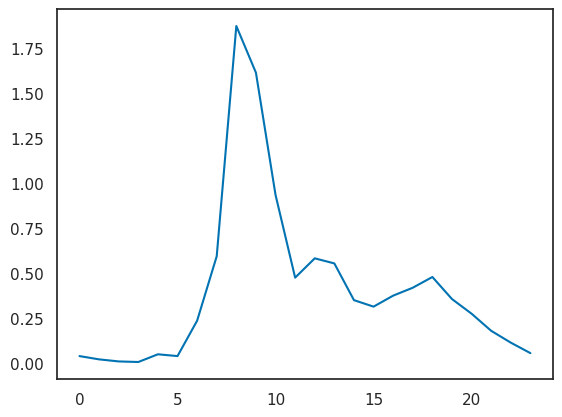

In [6]:
plt.plot(ev_generator.frequencies_per_hour)

In [7]:
evs = {}
for d, g in zip(durations, generators):
    evs[d] = []
    for i in dates:
        for s in charging_network.station_ids:
            evs[d] += g.generate(s, i)

In [8]:
arrivals = {
    f"scale={d}": [ev.arrival for ev in evs] for d, evs in evs.items()
}

arrivals.keys()

dict_keys(['scale=0.5', 'scale=1', 'scale=2', 'scale=3', 'scale=5', 'scale=10'])

In [9]:
# fig = plot_times(times=arrivals.values(), labels=arrivals.keys())
# fig.legend()
# fig.savefig("arrivals_clock.pdf", dpi=300)

In [10]:
departures = {
    f"scale={d}": [ev.departure for ev in evs] for d, evs in evs.items()
}

departures.keys()

dict_keys(['scale=0.5', 'scale=1', 'scale=2', 'scale=3', 'scale=5', 'scale=10'])

In [11]:
# fig = plot_times(times=departures.values(), labels=departures.keys())
# fig.legend()
# fig.savefig("departures_clock.pdf", dpi=300)

In [12]:
durations = {
    f"scale={d}": [ev.departure for ev in evs] for d, evs in evs.items()
}

durations.keys()

dict_keys(['scale=0.5', 'scale=1', 'scale=2', 'scale=3', 'scale=5', 'scale=10'])

In [13]:
# fig = plot_times(times=durations.values(), labels=durations.keys())
# fig.legend()
# fig.savefig("durations_clock.pdf", dpi=300)

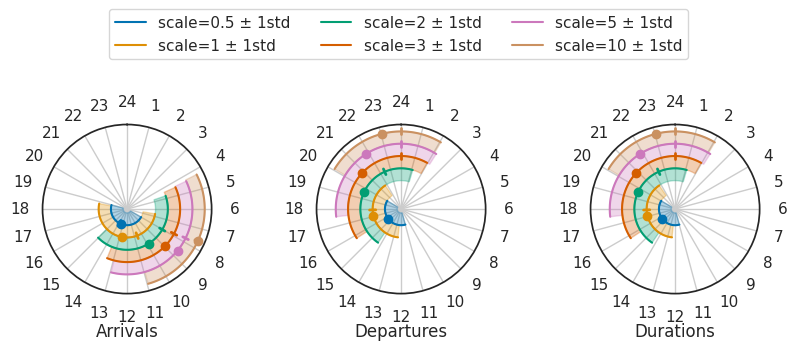

In [14]:
m = 2.8
fig, axs = plt.subplots(
    1,
    3,
    subplot_kw={'projection': 'polar'}, figsize=(m * 3, m),
    tight_layout=True,
)

for ax, (l, v) in zip(axs, {"Arrivals": arrivals, "Departures": departures, "Durations": durations}.items()):
    f = plot_times(times=v.values(), labels=v.keys(), ax=ax)
    ax.set_title(l, y=-0.3)
    # ax.set_title(l, y=-0.25)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="center", ncols=3, bbox_to_anchor=(0.5, 1.15))
fig.subplots_adjust(wspace=0.3)
fig.savefig("duration_mult.pdf", dpi=300, bbox_inches="tight")

In [15]:
import numpy as np

d = {
    "keys": [],
    "#EVs": [],
    "requested energy": [],
    "initial charge":[],
    "max power": [],
}

for key, value in evs.items():
    d["keys"].append(f"multiplictor={key}")
    d["requested energy"].append([ev.requested_energy for ev in value])
    d["initial charge"].append([ev._battery._init_charge for ev in value])
    d["max power"].append([ev.maximum_charging_power for ev in value])
    d["#EVs"].append(len(value))

ic| metric: '#EVs'


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

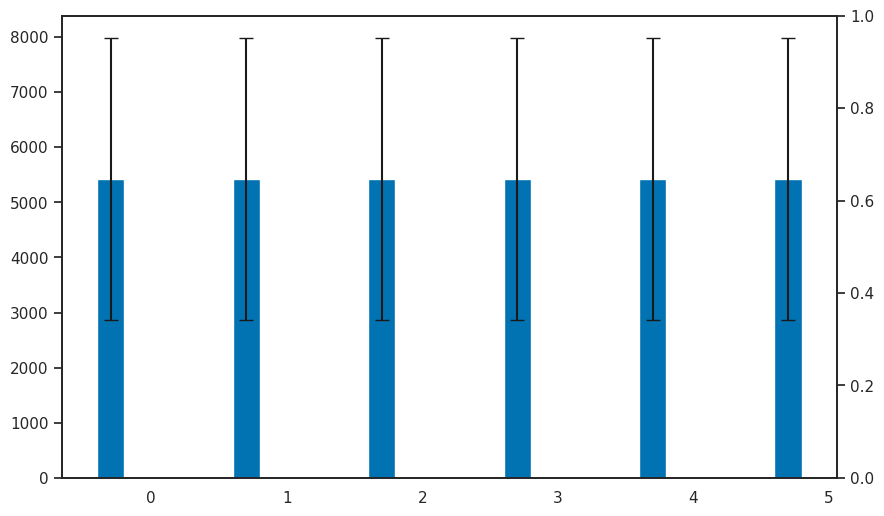

In [16]:
import matplotlib.pyplot as plt
import numpy as np

keys = d["keys"]
metrics = [k for k in d.keys() if k != "keys"]

N = len(keys)      # number of groups
M = len(metrics)   # number of bars per group

x = np.arange(N)   # the label locations

# Bar width with some padding (1.2 is padding factor)
bar_width = 1.0 / (M + 1)

fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()

for i, metric in enumerate(metrics):
    # Compute offset for this metric's bars
    offset = (i - (M - 1) / 2) * bar_width
    values = d[metric]
    means = np.mean(values)
    stds = np.std(values)
    
    ic(metric)

    if metric == "#EVs":
        bars = ax.bar(x + offset,
                      means,
                      bar_width,
                      label=metric,
                      yerr=stds, 
                      capsize=5,
                      color=color_cycle[i],
                      )
    else:
        bars = ax2.bar(x + offset,
                       means,
                       bar_width,
                       yerr=stds,
                       capsize=5,
                       label=metric, color=color_cycle[i],
                       )

    # Optional: annotate bars with values
    # for bar in bars:
    #     height = bar.get_height()
    #     ax.annotate(f'{height:.2f}',
    #                 xy=(bar.get_x() + bar.get_width() / 2, height),
    #                 xytext=(0, 3),  # offset label slightly above bar
    #                 textcoords="offset points",
    #                 ha='center', va='bottom', fontsize=8)

# ax.set_xlabel('Keys')
ax.set_xticks(x)
ax.set_xticklabels(keys)
# ax.legend()

handles, labels = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
handles += h2
labels += l2

ax2.set_ylabel("kWh")
ax.set_ylabel("#EVs")

fig.legend(handles, labels, loc="center", ncols=4, bbox_to_anchor=(0.5, 1))
fig.subplots_adjust(wspace=0.4)
fig.savefig("statistics.pdf", dpi=300, bbox_inches="tight")